In [35]:
using DataFrames, CSV, MLJLinearModels, MLJ, VegaLite

In [72]:
# Import training dataset
lichen_training = CSV.read("C:/Users/julio/Downloads/lichen_training.csv", DataFrame) |>
x -> select(x, "Total.lichen", "basal_area", "PL", "mean_Long", "mean_Lat", "Aspect_south", "SX") |>
x -> rename(x, ["biomass", "basalarea", "pl", "lon", "lat", "south", "sx"]) |>
x -> coerce(x, Count => Continuous);

In [73]:
schema(lichen_training)

┌───────────┬─────────┬────────────┐
│ _.names   │ _.types │ _.scitypes │
├───────────┼─────────┼────────────┤
│ biomass   │ Float64 │ Continuous │
│ basalarea │ Float64 │ Continuous │
│ pl        │ Float64 │ Continuous │
│ lon       │ Float64 │ Continuous │
│ lat       │ Float64 │ Continuous │
│ south     │ Float64 │ Continuous │
│ sx        │ Float64 │ Continuous │
└───────────┴─────────┴────────────┘
_.nrows = 78


In [74]:
# Split predictors (X) and response variable (y)
y, X = unpack(lichen_training, ==(:biomass), _ -> true);

In [75]:
# Load a LinearRegressor using the GLM package
LinearRegressor = @load LinearRegressor pkg=MLJLinearModels

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\julio\.julia\packages\MLJModels\GKDnU\src\loading.jl:168


MLJLinearModels.LinearRegressor

In [76]:
# Instantiate a linear regressor model using a pipeline
LinearRegressorPipe = @pipeline(Standardizer(), LinearRegressor())

Pipeline280(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    linear_regressor = LinearRegressor(
            fit_intercept = true,
            solver = nothing))

In [77]:
# Create an MLJ machine (model + data)
LinearModel = machine(LinearRegressor(), X, y)

Machine{LinearRegressor,…} trained 0 times; caches data
  args: 
    1:	Source @333 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @714 ⏎ `AbstractVector{Continuous}`


In [78]:
# Split into train/test datasets
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=1010)

([66, 63, 5, 22, 49, 15, 47, 64, 35, 12  …  11, 67, 54, 73, 32, 4, 62, 61, 57, 21], [14, 78, 40, 27, 74, 68, 18, 2, 53, 50  …  77, 29, 69, 7, 60, 59, 17, 30, 43, 51])

In [79]:
# Fit the machine
fit!(LinearModel, rows=train)

┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403


Machine{LinearRegressor,…} trained 1 time; caches data
  args: 
    1:	Source @333 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @714 ⏎ `AbstractVector{Continuous}`


In [80]:
# Check trained parameters
fp = fitted_params(LinearModel)

(coefs = [:basalarea => -27.47074270396439, :pl => 7.676320940401087, :lon => -146.45163457348735, :lat => -122.86240941507849, :south => -212.46989463113562, :sx => 5.998208027586419],
 intercept = -10596.646306509354,)

In [81]:
# Make predictions on test
y_test_pred = predict(LinearModel, rows=test)

23-element Vector{Float64}:
  894.7820135144575
  687.6893417791052
  317.14895879768846
 1265.7536969317825
  305.3678696534498
  579.388518850461
  818.4860103393221
  665.6670287380475
  274.79228856591544
  658.8677247451342
    ⋮
 1093.4869382757606
  359.9791331606666
 -179.3166878261418
  590.4633078640418
 1006.5220281687398
  404.43392835669147
  647.6588529887576
  375.7584071333349
 1018.9577228878043

In [82]:
rms(y_test_pred, y[test])

865.3096052696646

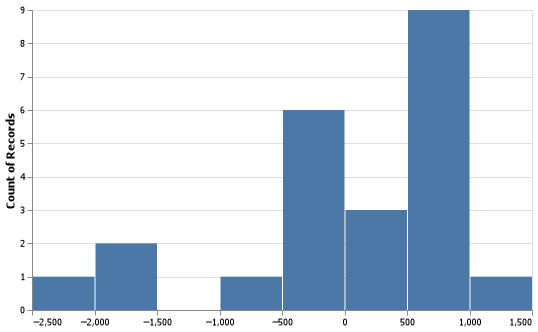

In [83]:
residuals = y_test_pred - y[test]
@vlplot(
    width=500,
    height=300,
    :bar, x={residuals, bin=true}, y="count()")

# Predict on new dataset

In [11]:
# Import CSV to dataframe, select the same columns used for training
lichen = CSV.read("C:/Users/julio/Downloads/predicted_biomass_Nov2021.csv", DataFrame; missingstring="") |>
x -> select(x, :BASAL_AREA, :PL, :LON) |>
x -> rename(x, ["basalarea", "pl", "lon"]);

In [12]:
biomass = predict(LinearModel, lichen)

213821-element Vector{Float64}:
  717.7831826806851
  487.9561812325737
  611.1903162110848
  950.6845916459515
 1230.6339243731927
  523.4791277369459
  523.0290931091513
  581.7236368235353
  496.66319059141097
  731.7563375983846
    ⋮
  647.3013626223183
   35.21271513672582
  819.481575762582
  285.14750389258916
  -59.814468698155906
 -331.44522683402283
  -80.05253386673758
  442.1927789772835
  525.8023712031008